<a href="https://colab.research.google.com/github/Renaldinho/ML-ImageClassification/blob/main/data-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import dependencies**


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate
import torchvision
from collections import Counter
import torch

**Load training and test datasets **

In [2]:
train_dataset = torchvision.datasets.EMNIST(
    root='./data',
    split='digits',
    train=True,
    download=True,
    transform=None
)

test_dataset = torchvision.datasets.EMNIST(
    root='./data',
    split='digits',
    train=False,
    download=True,
    transform=None
)



100%|██████████| 562M/562M [00:39<00:00, 14.3MB/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


**Inspect data inside 1 entry**

In [3]:
image, label = train_dataset[0]
print(f"Image shape: {len(np.array(image).flatten())}")
print(f"Label: {label}")

Image shape: 784
Label: 8


**Inspect number of examples for each label** (Dataset summary says balanced but i don't trust it)

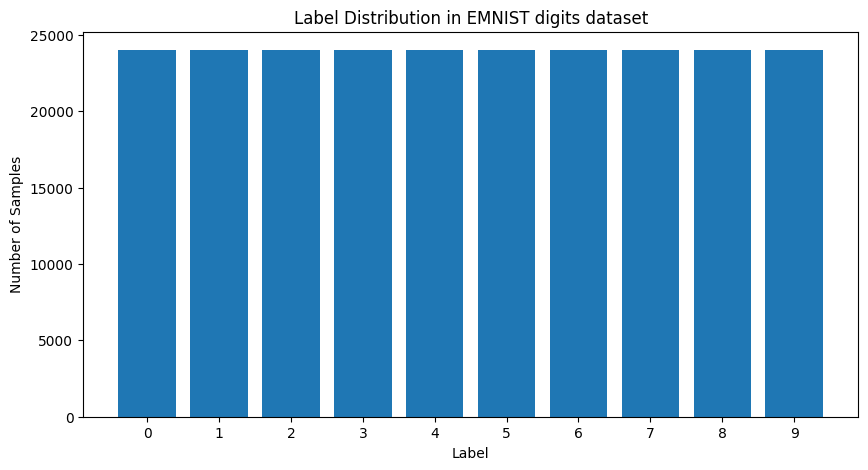

In [4]:
labels = [label for _, label in train_dataset]

# Count the occurrences of each label
label_counts = Counter(labels)

# Prepare data for the plot
label_indices = sorted(label_counts.keys())  # Sorted labels
counts = [label_counts[label] for label in label_indices]

plt.figure(figsize=(10, 5))
plt.bar(label_indices, counts)
plt.xlabel("Label")
plt.ylabel("Number of Samples")
plt.title("Label Distribution in EMNIST digits dataset")
plt.xticks(label_indices)
plt.show()

**Display data for 10 entries**

In [14]:
# Prepare data for the table
table_data = []
for i in range(10):  # Get the first 10 entries
    image, label = train_dataset[i]
    image_array = np.array(image).flatten()
    table_data.append([label] + image_array.tolist())

# Create headers for the table
headers = ["label"] + [f"pixel_{i}" for i in range(len(image_array))]

# Display the table using tabulate (commented out cause it looks horendous in github when viewing notebook)
##print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

**Display the images that the data represents**

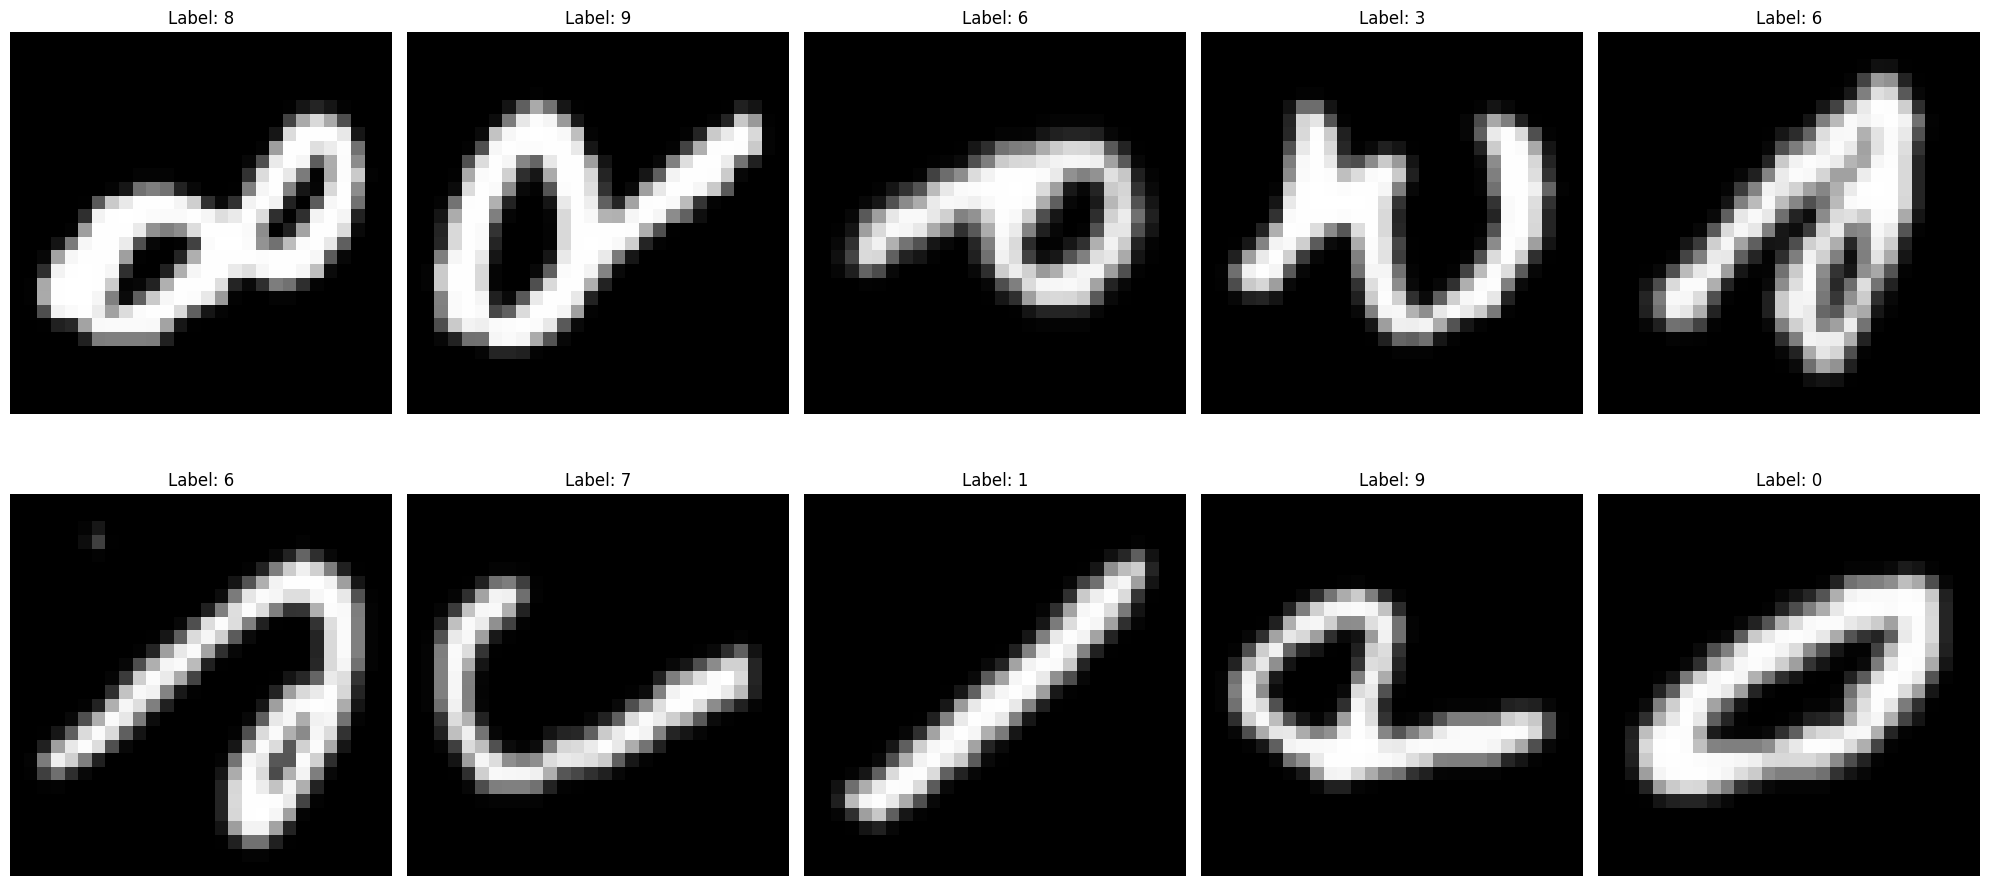

In [6]:

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# Display the first 10 images
for i in range(10):
    row = i // 5
    col = i % 5
    image, label = train_dataset[i]
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f'Label: {label}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

**Dimensionality reduction approached**



In [7]:
from torchvision.transforms import ToTensor


if train_dataset.transform is None:
    train_dataset.transform = ToTensor()

# Create a DataLoader
batch_size = 64  # Adjust based on your memory capacity
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


# Initialize lists to store all images and labels
all_images = []
all_labels = []

# Iterate through the DataLoader
for images, labels in data_loader:
    # Convert images to NumPy arrays and flatten them
    images_np = images.numpy()
    images_flattened = images_np.reshape(images_np.shape[0], -1)
    all_images.append(images_flattened)
    all_labels.append(labels.numpy())

# Concatenate the arrays
all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Now you have all_images and all_labels ready for dimensionality reduction
print(all_images.shape)  # Should output (number_of_images, 784)
print(all_labels.shape)  # Should output (number_of_images,)

(240000, 784)
(240000,)


In [15]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def reduce_dimensions(images, method='none', n_components=2, perplexity=30):
  """Reduces dimensionality using the specified method."""

  # Flatten and convert to NumPy array as the first step
  images_np = np.array([np.array(img).flatten() for img in images])

  if method == 'pca':
    pca = PCA(n_components=n_components)
    return pca.fit_transform(images_np)
  elif method == 'tsne':
    tsne = TSNE(n_components=n_components, perplexity=perplexity, n_iter=500)  # Adjust n_iter if needed
    return tsne.fit_transform(images_np)
  else:  # method == 'none'
    return images_np  # No dimensionality reduction

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


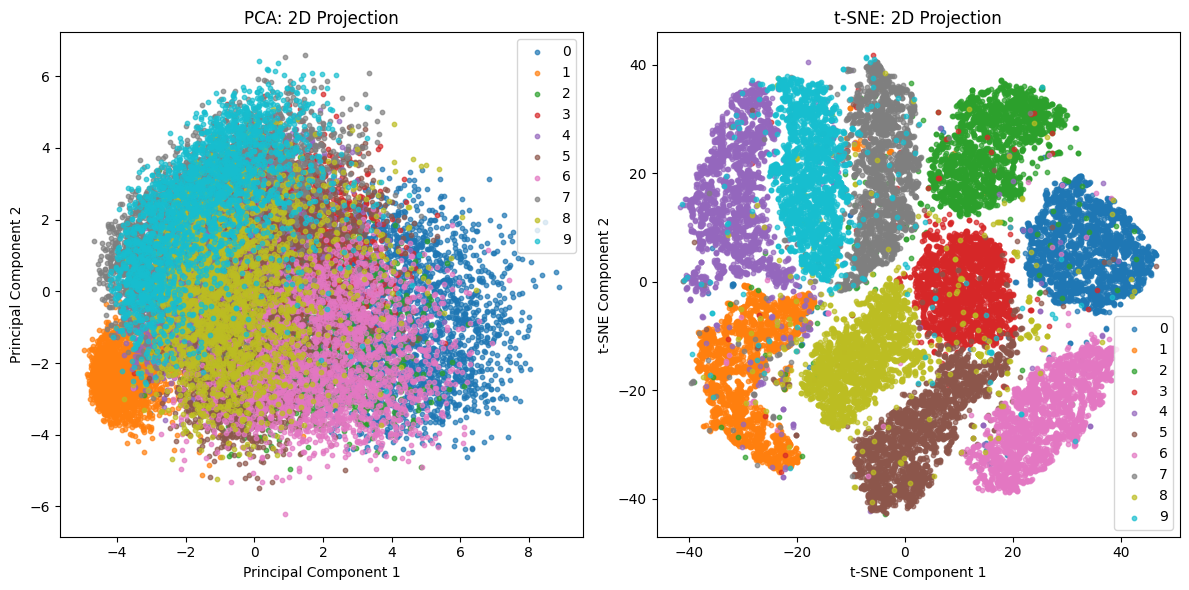

In [16]:
# Apply dimensionality reduction to the first 100 samples
amount_of_data = 24000
reduced_images_pca = reduce_dimensions(all_images[:amount_of_data], method='pca')
reduced_images_tsne = reduce_dimensions(all_images[:amount_of_data], method='tsne')

# Visualize the reduced data
plt.figure(figsize=(12, 6))

# PCA subplot
plt.subplot(1, 2, 1)
for i in range(10):  # Loop through digit classes (0-9)
    plt.scatter(reduced_images_pca[all_labels[:amount_of_data] == i, 0], reduced_images_pca[all_labels[:amount_of_data] == i, 1], label=str(i), alpha=0.7, s=10)
plt.title("PCA: 2D Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()

# t-SNE subplot
plt.subplot(1, 2, 2)
for i in range(10):  # Loop through digit classes (0-9)
    plt.scatter(reduced_images_tsne[all_labels[:amount_of_data] == i, 0], reduced_images_tsne[all_labels[:amount_of_data] == i, 1], label=str(i), alpha=0.7, s=10)
plt.title("t-SNE: 2D Projection")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()

plt.tight_layout()
plt.show()